<a href="https://colab.research.google.com/github/Janmejay1998/Newspaper-Summarization-Analysis/blob/main/Newspaper_Summarization_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install rouge_score      # Installing rouge_score library

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=589a4ade8ee6dd6cab7e29b54ce17128c67a927c1dfa661f68487f49c16367bc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFPegasusModel, TFPegasusForConditionalGeneration
import tensorflow as tf
from rouge_score import rouge_scorer

In [57]:
df = pd.read_excel('Sample Dataset for Validation.xlsx')

In [58]:
df.head()

,Please write the Name of Newspaper - Newspaper Must be Indian English Newspaper listed above,PUBLICATION DATE of News\nDate when the news article was published.,Headline of News Article\nHeadline / Title of the News Article from Source,"Content in detail of News article\nArticle in detail from data source (Make sure, data must be very clear)",Human Summary For Article (Use Bard/ChatGpt)\nWrite a summary of the article. Explain the news in your own words. Minimum 50 words and maximum 200 words
0,Mint,2012-03-23,Views | Dim sum bonds in tandoori land,In a move that could help them reduce borrowin...,The Reserve Bank of India has permitted Indian...
1,The Times of India,2003-11-23,Hazare and Patkar: Do or die,The complete lack of integrity and commitment ...,India's political landscape is criticized for ...
2,The Times of India,2020-11-22,India successfully tests hypersonic technology...,The Defence Research and Development Organisat...,India successfully tests a key component for h...
3,The Times of India,2016-01-01,New Year bashes for some turn less groovy and ...,NAVI MUMBAI: It’s not all rock and roll or hav...,Many residents in Navi Mumbai opted for low-ke...
4,The Times of India,2020-11-22,Scientists develop AI-powered tool to predict ...,Researchers from the Indian Institute of Techn...,Indian scientists create an AI tool that uses ...


In [59]:
new_col_names = ['Newspaper','Date','Headline','Article','ChatGPT Generated Summary']
col_name_dict = {old_col: new_col for old_col, new_col in zip(df.columns,new_col_names)}
df.rename(columns=col_name_dict, inplace=True)

In [60]:
df.head()

,Newspaper,Date,Headline,Article,ChatGPT Generated Summary
0,Mint,2012-03-23,Views | Dim sum bonds in tandoori land,In a move that could help them reduce borrowin...,The Reserve Bank of India has permitted Indian...
1,The Times of India,2003-11-23,Hazare and Patkar: Do or die,The complete lack of integrity and commitment ...,India's political landscape is criticized for ...
2,The Times of India,2020-11-22,India successfully tests hypersonic technology...,The Defence Research and Development Organisat...,India successfully tests a key component for h...
3,The Times of India,2016-01-01,New Year bashes for some turn less groovy and ...,NAVI MUMBAI: It’s not all rock and roll or hav...,Many residents in Navi Mumbai opted for low-ke...
4,The Times of India,2020-11-22,Scientists develop AI-powered tool to predict ...,Researchers from the Indian Institute of Techn...,Indian scientists create an AI tool that uses ...


In [61]:
# Checking Null Values
df.isna().sum()

Newspaper                    0
Date                         0
Headline                     0
Article                      0
ChatGPT Generated Summary    0
dtype: int64

In [63]:
# Initializing Model
model_name = "google/pegasus-xsum"
model = TFPegasusForConditionalGeneration.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# Create empty lists to store generated summaries and ROUGE scores
generated_summaries = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Set the maximum sequence length
max_seq_length = 512

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    article_to_summarize = row['Article']
    reference_summary = row['ChatGPT Generated Summary']

    # Truncate or pad the article content to fit the maximum sequence length
    inputs = tokenizer(article_to_summarize,max_length=max_seq_length, truncation=True, return_tensors="tf")

    # Generate Summary
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    generated_summaries.append(generated_summary)

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(generated_summary, reference_summary)

    # Print ROUGE scores
    print(f"Index: {index}")
    print("Generated Summary:", generated_summary)
    print("Reference Summary:", reference_summary)
    print("ROUGE-1 Score:", scores['rouge1'].fmeasure)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    print("ROUGE-2 Score:", scores['rouge2'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    print("ROUGE-L Score:", scores['rougeL'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)
    print()

# Add generated summaries and ROUGE scores as new columns in the DataFrame
df['Pegasus Generated Summary'] = generated_summaries
df['ROUGE-1'] = rouge1_scores
df['ROUGE-2'] = rouge2_scores
df['ROUGE-L'] = rougeL_scores


Index: 0
Generated Summary: Indian power firms could be beneficiaries of a move by India’s central bank to ease their borrowing costs from China.
Reference Summary: The Reserve Bank of India has permitted Indian companies with ties to China to raise debt in Chinese renminbi, allowing transactions to be settled directly in the Chinese currency. This move, aimed at reducing borrowing costs, is particularly beneficial for Indian power firms as the country targets 100,000MW of additional electricity capacity in the next five years, requiring over $400 billion in investment. With India-China trade growing at 40% year-on-year, the facility to borrow in renminbi streamlines transactions and potentially eases financing for crucial power sector projects, despite concerns over the increasing imports of power equipment from China.
ROUGE-1 Score: 0.22764227642276424
ROUGE-2 Score: 0.06611570247933884
ROUGE-L Score: 0.14634146341463417

Index: 1
Generated Summary: In our series of letters from Indi

In [66]:
df.head()

,Newspaper,Date,Headline,Article,ChatGPT Generated Summary,Pegasus Generated Summary,ROUGE-1,ROUGE-2,ROUGE-L
0,Mint,2012-03-23,Views | Dim sum bonds in tandoori land,In a move that could help them reduce borrowin...,The Reserve Bank of India has permitted Indian...,Indian power firms could be beneficiaries of a...,0.227642,0.066116,0.146341
1,The Times of India,2003-11-23,Hazare and Patkar: Do or die,The complete lack of integrity and commitment ...,India's political landscape is criticized for ...,In our series of letters from Indian journalis...,0.121739,0.000000,0.086957
2,The Times of India,2020-11-22,India successfully tests hypersonic technology...,The Defence Research and Development Organisat...,India successfully tests a key component for h...,India has become the first country in the worl...,0.250000,0.066667,0.250000
3,The Times of India,2016-01-01,New Year bashes for some turn less groovy and ...,NAVI MUMBAI: It’s not all rock and roll or hav...,Many residents in Navi Mumbai opted for low-ke...,"As 2008 draws to a close, residents of the cit...",0.120301,0.015267,0.060150
4,The Times of India,2020-11-22,Scientists develop AI-powered tool to predict ...,Researchers from the Indian Institute of Techn...,Indian scientists create an AI tool that uses ...,This article looks at the potential applicatio...,0.108108,0.000000,0.054054


In [67]:
# Saving Pegasus modify dataset locally
df.to_csv("Pegasus News Dataset.csv", index=False)

In [91]:
df.head()

,Newspaper,Date,Headline,Article,ChatGPT Generated Summary,Pegasus Generated Summary,ROUGE-1,ROUGE-2,ROUGE-L
0,Mint,2012-03-23,Views | Dim sum bonds in tandoori land,In a move that could help them reduce borrowin...,The Reserve Bank of India has permitted Indian...,Indian power firms could be beneficiaries of a...,0.227642,0.066116,0.146341
1,The Times of India,2003-11-23,Hazare and Patkar: Do or die,The complete lack of integrity and commitment ...,India's political landscape is criticized for ...,In our series of letters from Indian journalis...,0.121739,0.000000,0.086957
2,The Times of India,2020-11-22,India successfully tests hypersonic technology...,The Defence Research and Development Organisat...,India successfully tests a key component for h...,India has become the first country in the worl...,0.250000,0.066667,0.250000
3,The Times of India,2016-01-01,New Year bashes for some turn less groovy and ...,NAVI MUMBAI: It’s not all rock and roll or hav...,Many residents in Navi Mumbai opted for low-ke...,"As 2008 draws to a close, residents of the cit...",0.120301,0.015267,0.060150
4,The Times of India,2020-11-22,Scientists develop AI-powered tool to predict ...,Researchers from the Indian Institute of Techn...,Indian scientists create an AI tool that uses ...,This article looks at the potential applicatio...,0.108108,0.000000,0.054054


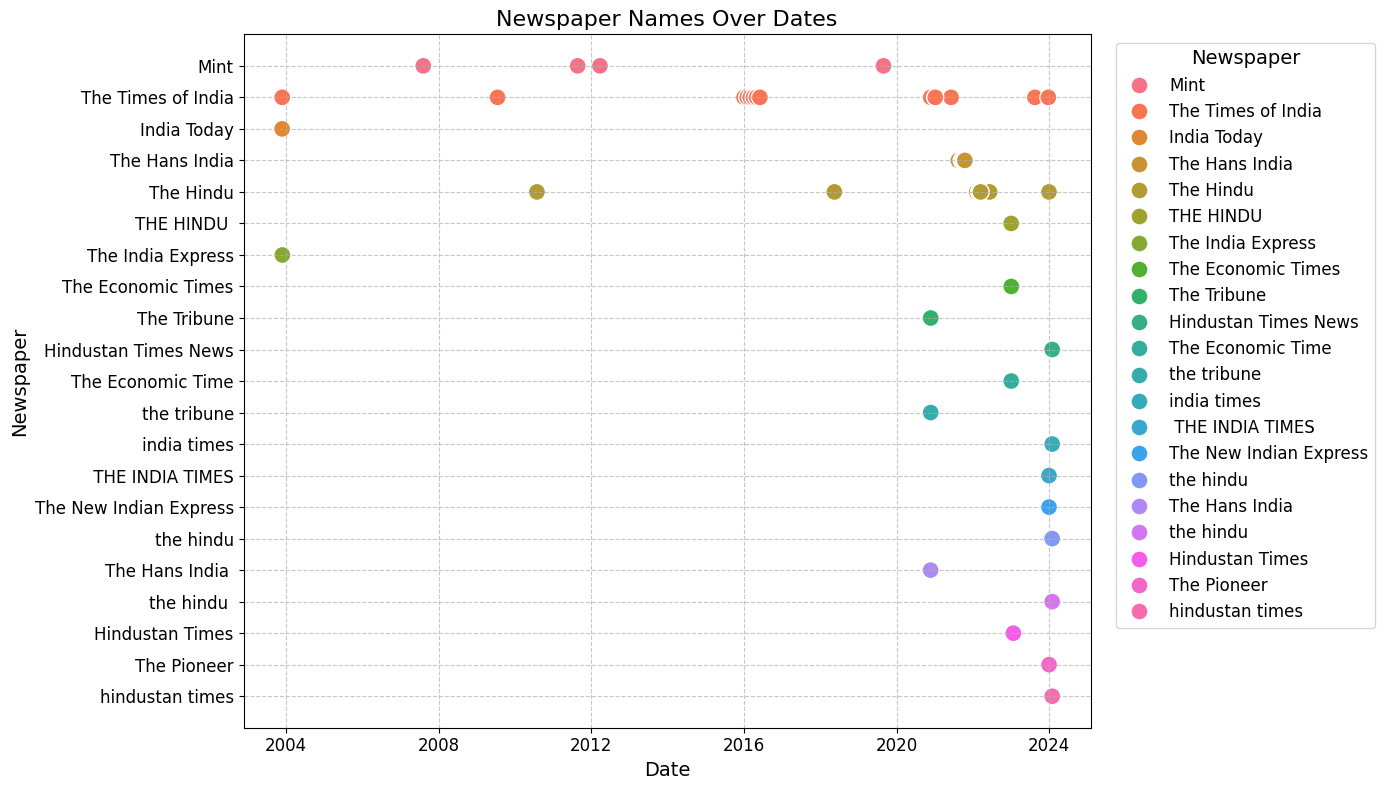

In [100]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define a custom color palette
colors = sns.color_palette("husl", n_colors=len(df['Newspaper'].unique()))

# Plot newspaper names over dates
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='Date', y='Newspaper', hue='Newspaper', palette=colors, marker='o', s=150)
plt.title('Newspaper Names Over Dates', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Newspaper', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Move the legend outside the plot area
plt.legend(title='Newspaper', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Average ROUGE-1 Score: 0.22867
Average ROUGE-2 Score: 0.07412
Average ROUGE-L Score: 0.15834


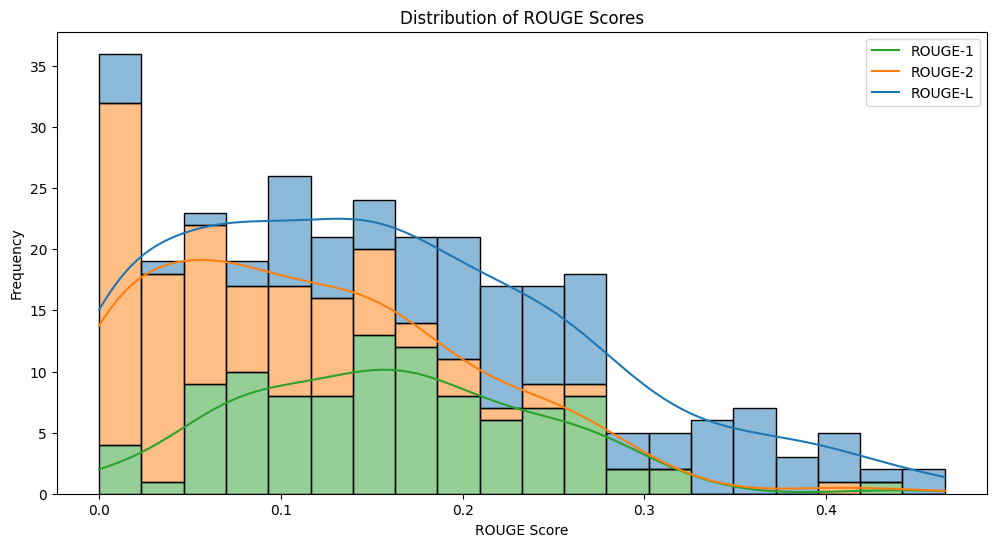

In [87]:
# Compute average ROUGE scores
avg_rouge1 = df['ROUGE-1'].mean()
avg_rouge2 = df['ROUGE-2'].mean()
avg_rougeL = df['ROUGE-L'].mean()

# Print average ROUGE scores
print("Average ROUGE-1 Score:", round(avg_rouge1,5))
print("Average ROUGE-2 Score:", round(avg_rouge2,5))
print("Average ROUGE-L Score:", round(avg_rougeL,5))

# Plot distribution of ROUGE scores
plt.figure(figsize=(12, 6))
sns.histplot(data=df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']], bins=20, kde=True, multiple="stack")
plt.title('Distribution of ROUGE Scores')
plt.xlabel('ROUGE Score')
plt.ylabel('Frequency')
plt.legend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
plt.show()

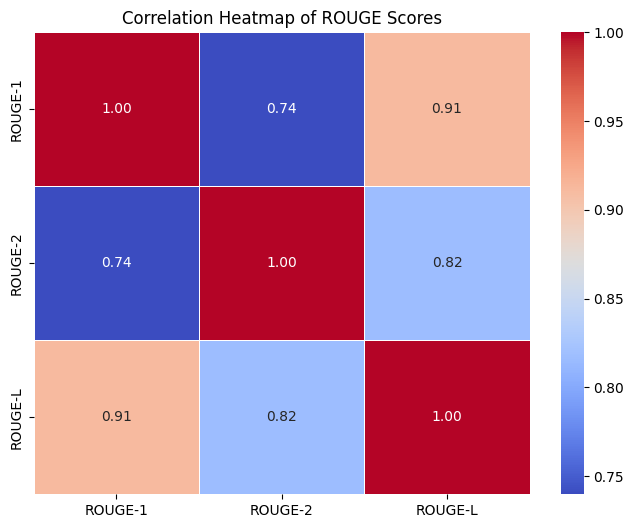

In [85]:
# Compute correlation matrix between ROUGE scores
rouge_scores = df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']]
correlation_matrix = rouge_scores.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of ROUGE Scores')
plt.show()

In [88]:
# Analysis statements based on ROUGE scores
if avg_rouge1 > 0.5:
    print("The model demonstrates strong performance in capturing important unigrams from the original text.")
else:
    print("The model's performance in capturing unigrams from the original text needs improvement.")

if avg_rouge2 > 0.3:
    print("The model performs well in preserving the sequence of words and capturing phrases from the original text.")
else:
    print("The model's ability to capture bigrams from the original text is limited.")

if avg_rougeL > 0.4:
    print("The model excels in capturing the overall structure and content flow of the original text.")
else:
    print("The model's performance in preserving the content flow of the original text needs improvement.")

The model's performance in capturing unigrams from the original text needs improvement.
The model's ability to capture bigrams from the original text is limited.
The model's performance in preserving the content flow of the original text needs improvement.


In [89]:
!pip freeze > requirements.txt